In [190]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
import pandas as pd
np.random.seed(1234)

In [94]:
#Quadratic potential
potential = lambda x,y: ((x**2+y**2)+0.1*np.cos((x**2+y**2)**0.5/0.1))
vpotential = np.vectorize(potential)

def grad(x,y):
    return np.array([(2*x-np.sin(10*x))*(y**2+0.1*np.cos(y/0.1)), (2*y-np.sin(10*y))*(x**2+0.1*np.cos(x/0.1))])
vgrad = np.vectorize(grad)

In [129]:
#Muller Brown Potential and Gradient

def MB_potential(x,y):    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value
vMB_potential = np.vectorize(Muller_Brown_potential)

def grad_MB(x,y):
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dx = 0
    dy = 0
    for j in range(0, 4):
        dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return dx, dy

In [177]:
# Training
def train(N = 1000, learning_rate = 1e-3, a = 1):
    #initialise data
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    for i in range(N):
        dx, dy = grad_MB(x,y)
        x -= learning_rate*dx
        y -= learning_rate*dy
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
    return points_x, points_y

def train_nesterov(N = 1000, learning_rate = 1e-3, a = 1):
    #initialise data
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    for i in range(1, N+1):
        dx, dy = grad_MB(u,v)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (i-1)/(i+2)*(x_new-x)
        v = y_new + (i-1)/(i+2)*(y_new-y)
        
        x = x_new
        y = y_new
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
    return points_x, points_y

def train_sgd(N = 1000, learning_rate = 1e-3, a = 1, beta = 1):
    #initialise data
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    for i in range(1, N+1):
        dx, dy = grad_MB(x,y)
        x -= learning_rate*dx + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        y -= learning_rate*dy + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
    return points_x, points_y

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

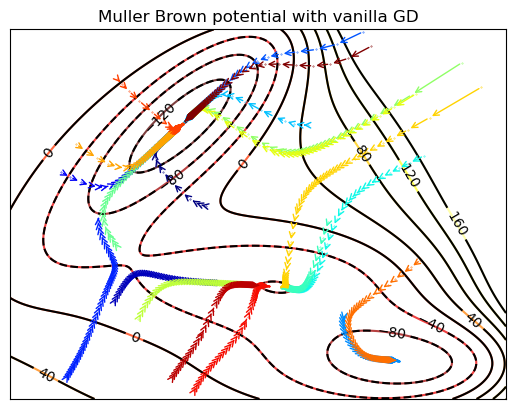

In [183]:
#Vanilla GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,ntraj))# Initialize holder for trajectories
minima_vanilla = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train(1000, learning_rate = 1e-5, a = 1)
    minima_vanilla.append(MB_potential(points_x[-1],points_y[-1]))
    plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
    for i in range(len(points_x) - 1):
        plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                     arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                     va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with vanilla GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

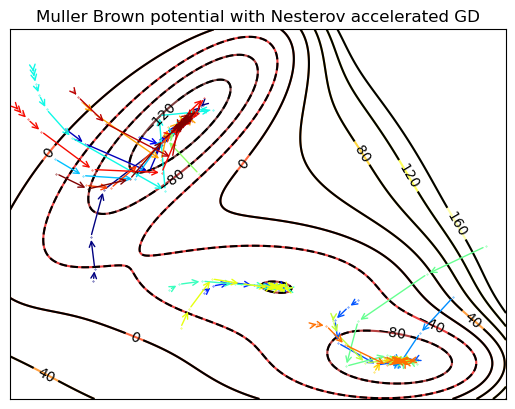

In [187]:
#Nesterov Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,ntraj))# Initialize holder for trajectories
minima_nesterov = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_nesterov(1000, learning_rate = 1e-5, a = 1)
    minima_nesterov.append(MB_potential(points_x[-1],points_y[-1]))
    plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
    for i in range(len(points_x) - 1):
        plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                     arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                     va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

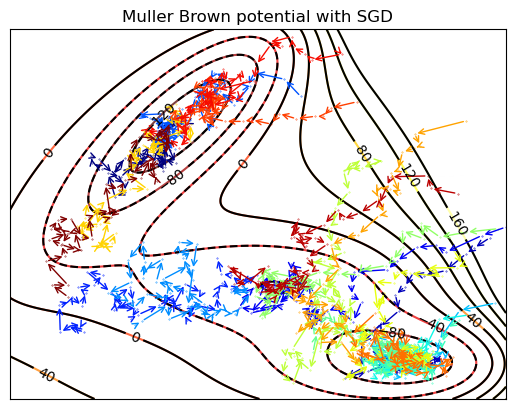

In [195]:
#sgd

#Nesterov Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,ntraj))# Initialize holder for trajectories
minima_sgd = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_sgd(1000, learning_rate = 1e-5, a = 1, beta = 0.1)
    plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
    minima_sgd.append(MB_potential(points_x[-1],points_y[-1]))
    for i in range(len(points_x) - 1):
        plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                     arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                     va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with SGD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

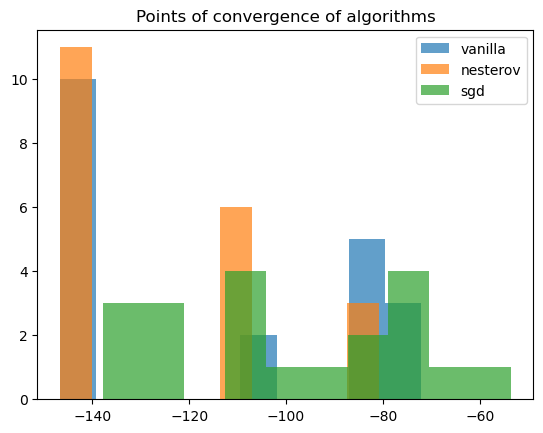

In [197]:
cols = ['vanilla', 'nesterov', 'sgd']
df = pd.DataFrame(columns=cols)

plt.title('Points of convergence of algorithms')
plt.hist(minima_vanilla, alpha = 0.7, label = 'vanilla')
plt.hist(minima_nesterov, alpha = 0.7, label = 'nesterov')
plt.hist(minima_sgd, alpha = 0.7, label = 'sgd')
plt.legend()

([], [])

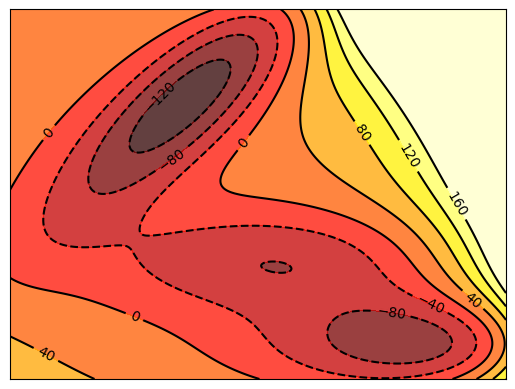

In [133]:
#contour plot of Muller-Brown potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])